In [30]:
from PIL import Image
import requests
from io import BytesIO

Differences between automatic topic modeling and topic classification.
1. In theory, unsupervised machine learning algorithms such as topic modeling require less manual input than supervised algorithms. That’s because they don't need to be trained by humans with manually tagged data. However, they do need high-quality data, and not only that – they need it in bucket loads, which may not always be easy to come by.
2. Topic modeling involves counting words and grouping similar word patterns to infer topics within unstructured data. Let’s say you’re a software company and you want to know what customers are saying about particular features of your product. Instead of spending hours going through heaps of feedback, in an attempt to deduce which texts are talking about your topics of interest, you could analyze them with a topic modeling algorithm.
3. However, if you have a list of predefined topics for a set of texts and want to label them automatically without having to read each one, as well as gain accurate insights, you’re better off using a topic classification algorithm.
4. Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA) for Topic Modelling - It is based on what is known as the distributional hypothesis which states that the semantics of words can be grasped by looking at the contexts the words appear in. In other words, under this hypothesis, the semantics of two words will be similar if they tend to occur in similar contexts


Use LDA for Topic Modelling and get input data for Topic Classificaiton - https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28

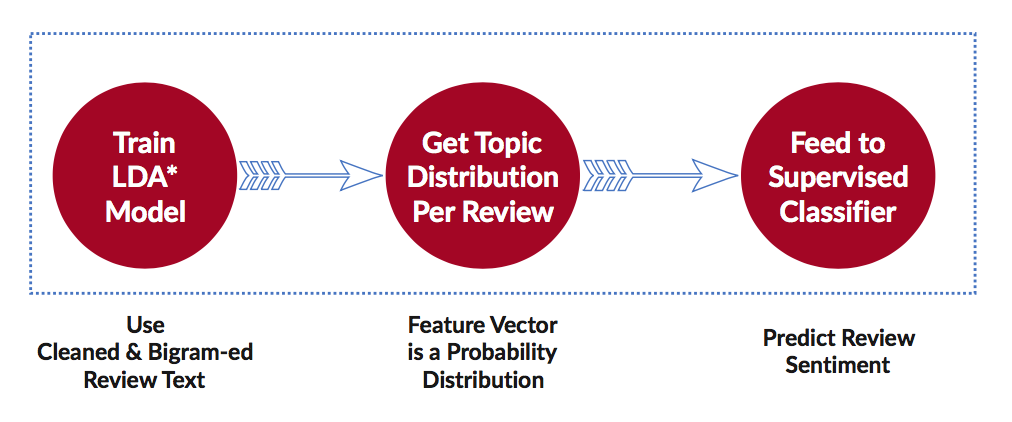

In [4]:
Image.open(BytesIO(requests.get("https://miro.medium.com/max/1400/1*s1shETDBzc7_qNDk0ngXQQ.png").content))

Bag of Words vs TF-IDF
.Word Embedding is one such technique where we can represent the text using vectors. The more popular forms of word embeddings are:BoW and TF-IDF



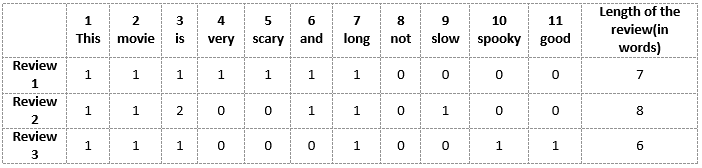

In [6]:
Image.open(BytesIO(requests.get("https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/BoWBag-of-Words-model-2.png").content))

BoW, which stands for Bag of Words. Drawbacks of using a Bag-of-Words (BoW) Model
1. In the above example, we can have vectors of length 11. However, we start facing issues when we come across new sentences:

2. If the new sentences contain new words, then our vocabulary size would increase and thereby, the length of the vectors would increase too.
3. Additionally, the vectors would also contain many 0s, thereby resulting in a sparse matrix (which is what we would like to avoid)
4. We are retaining no information on the grammar of the sentences nor on the ordering of the words in the text.

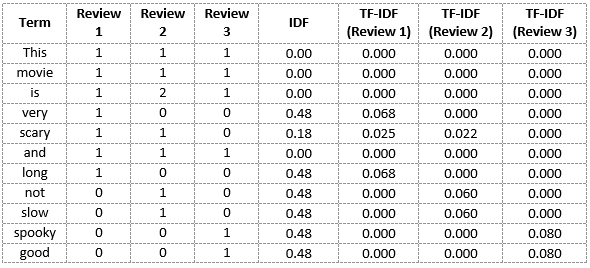

In [8]:
Image.open(BytesIO(requests.get("https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/TF_IDF-matrix.png").content))

TF-IDF, which stands for Term Frequency-Inverse Document Frequency.
1.  TF-IDF also gives larger values for less frequent words and is high when both IDF and TF values are high i.e the word is rare in all the documents combined but frequent in a single document.
2.  There still remained a void where understanding the context of words was concerned.
3. Detecting the similarity between the words ‘spooky’ and ‘scary’, or translating our given documents into another language, requires a lot more information on the documents.

This is where Word Embedding techniques such as Word2Vec, Continuous Bag of Words (CBOW), Skipgram, etc. come in. You can find a detailed guide to such techniques here:

Also these two TF-IDF and BoW can then be used for Information retrieval, Topic Modelling and Sentiment Analysis

# Preparing Data

1.  use NLTK to filter out stopwords
2. Stop words are those words in natural language that have a very little meaning, such as "is", "an", "the", etc. Search engines and other enterprise indexing platforms often filter the stop words while fetching results from the database against the user queries.Stop Words with NLTK, Gensim, SpaCy

In [1]:
import nltk


In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [4]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

In [5]:
lst_dics = []
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
## print the first one
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [6]:
## create dtf
dtf = pd.DataFrame(lst_dics)
## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
## rename columns
dtf = dtf.rename(columns={"category":"y", "headline":"text"})
## print 5 random rows
dtf.sample(5)

,y,text
10571,POLITICS,Michael Flynn’s Guilty Plea Pulls Vice Preside...
69370,POLITICS,Why Cruz Decided To Take On Trump
97100,POLITICS,Out of Line: The Uninvited
106563,ENTERTAINMENT,7 Times Lupita Nyong'o Challenged Us To Think ...
20910,POLITICS,Former CBO Directors Express 'Strong Objection...


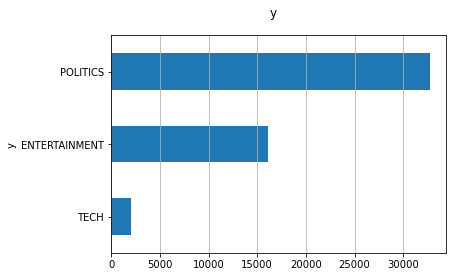

In [7]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

# Data Normalization

In [8]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and  characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [9]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [10]:
dtf["text_clean"] = dtf["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,y,text,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,morgan freeman devastated sexual harassment cl...


# Using Tf-Idf

In [11]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

In [12]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [13]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1.0, 'Sparse Matrix Sample')

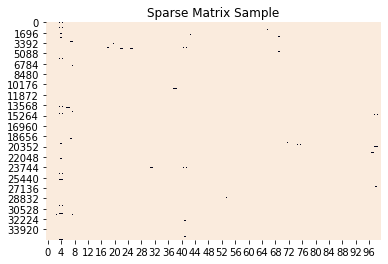

In [15]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [16]:
word = "new york"
dic_vocabulary[word]


6010

# Feature Selction

In [18]:
from sklearn import feature_selection

1. treat each category as binary (for example, the “Tech” category is 1 for the Tech news and 0 for the others);
2. perform a Chi-Square test to determine whether a feature and the (binary) target are independent;
3. keep only the features with a certain p-value from the Chi-Square test.

In [19]:
y = dtf_train["y"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

The chi-square test is used when you want to know whether there is a statistical difference between two categorical variables (e.g., gender and preferred car color).

The F test, on the other hand, is used when you want to know whether there is a statistical difference between two continuous variables (e.g., height and weight).

The chi-square test is non parametric. That means this test does not make any assumption about the distribution of the data.

The F test is a parametric test. It assumes that data are normally distributed and that samples are independent from one another.


In [20]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# ENTERTAINMENT:
  . selected features: 3076
  . top features: actor,album,award,box,box office,celebrity,clinton,dead,democrat,donald
 
# POLITICS:
  . selected features: 3034
  . top features: actor,album,apple,box,box office,clinton,dead,democrat,donald,donald trump
 
# TECH:
  . selected features: 444
  . top features: amazon,android,app,apple,apple rumor,apps,bug,car,computer,content
 


In [21]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

# Model

In [22]:
classifier = naive_bayes.MultinomialNB()

In [23]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [25]:
from sklearn import metrics

Accuracy: 0.91
Auc: 0.97
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.88      0.90      4794
     POLITICS       0.91      0.97      0.94      9829
         TECH       0.94      0.33      0.49       641

     accuracy                           0.91     15264
    macro avg       0.92      0.73      0.78     15264
 weighted avg       0.92      0.91      0.91     15264



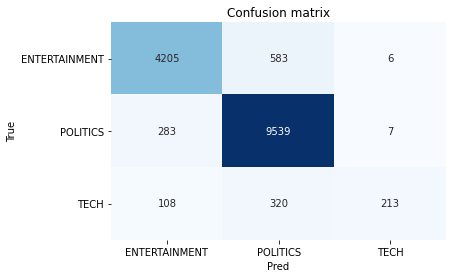

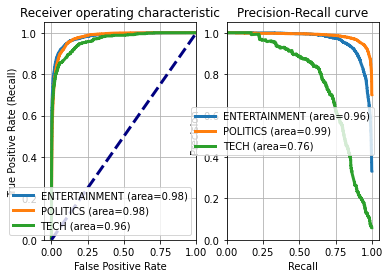

In [26]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [28]:
## select observation
i = 0
txt_instance = dtf_test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: ENTERTAINMENT --> Pred: ENTERTAINMENT | Prob: 0.83


# Word Embeddings by Word2Vec - Google, Glove - Stanford, Facebook - FastText

Word Embedding is the collective name for feature learning techniques where words from the vocabulary are mapped to vectors of real numbers. These vectors are calculated from the probability distribution for each word appearing before or after another. To put it another way, words of the same context usually appear together in the corpus, so they will be close in the vector space as well.

Word2Vec - 
1. The avalanche of word embeddings began in 2013 when researchers of Google around Tomas Mikolov published this paper. They proposed an approach, famously knows as Word2Vec. It uses small neural networks to calculate word embeddings based on words’ context. There are two approaches to implement this approach.
2. First, there is the continuous bag of words or CBOW. In this approach, the network tries to predict which word is most likely given its context. Words that are equally likely to appear can be interpreted as having a shared dimension. If we can replace “cat” with “dog” in a sentence, this approach predicts a similar probability for both. Therefore, we infer that the meaning of these words is similar on at least one level.
3. The second approach is skip-gram. The idea is very similar, but the network works the other way around. That is, it uses the target word to predict its context. 

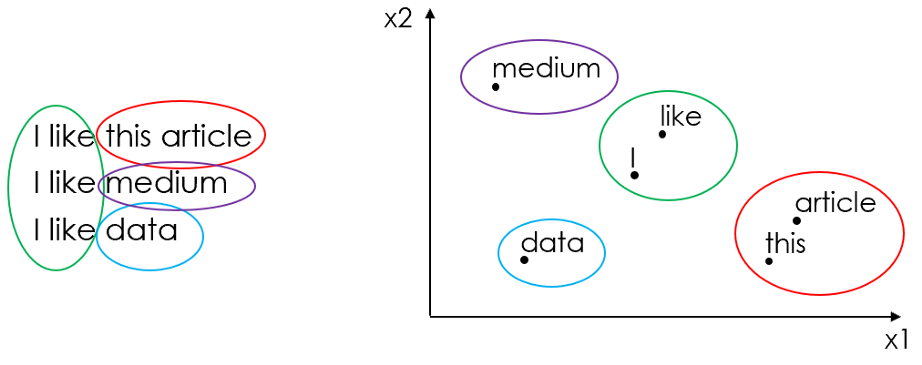

In [31]:
Image.open(BytesIO(requests.get("https://miro.medium.com/max/922/1*u67szEvNSMqrQeitdahw_A.png").content))

Glove - 
1. Word2Vec learns embeddings by relating target words to their context. However, it ignores whether some context words appear more often than others. For Word2Vec, a frequent co-occurrence of words creates more training examples, but it carries no additional information.
2. In contrast, GloVe stresses that the frequency of co-occurrences is vital information and should not be “wasted ”as additional training examples. Instead, GloVe builds word embeddings in a way that a combination of word vectors relates directly to the probability of these words’ co-occurrence in the corpus.

In [32]:
# nlp = gensim_api.load("word2vec-google-news-300")

Instead of using a pre-trained model, I am going to fit my own Word2Vec on the training data corpus with gensim. Before fitting the model, the corpus needs to be transformed into a list of lists of n-grams. In this particular case, I’ll try to capture unigrams (“york”), bigrams (“new york”), and trigrams (“new york city”).

In [148]:
corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)



In [100]:
lst_corpus[0]

['kylie', 'jenner', 'get', 'long', 'grey', 'lock', 'halloween']

In [101]:
corpus.iloc[0]

'kylie jenner get long grey lock halloween'

In [149]:
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases( lst_corpus, 
                 delimiter = " ", min_count=5, threshold=10)
#.encode
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

In [150]:

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ", min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [151]:
bigrams_detector.phrasegrams

{'kylie jenner': 825.7652844231792,
 'katy perry': 1578.3997718383312,
 'taylor swift': 771.1532998476678,
 'bad blood': 275.68081896551723,
 'san francisco': 2016.4082758620689,
 '15 minimum': 279.75658297611756,
 'minimum wage': 2371.6677482154446,
 'gop congressman': 42.60616353811409,
 'roy moore': 1146.3465625400077,
 'president obama': 16.695591777981637,
 'supreme court': 288.4930722402597,
 'wednesday morning': 454.7753393665158,
 'morning email': 347.605840146838,
 'donald trump': 26.457950780239955,
 'bill cosby': 150.8768405119031,
 'new york': 100.36372850166326,
 'tour date': 62.45283663704717,
 'tom price': 267.00321449444766,
 'even worse': 48.43281208587331,
 'kid rock': 16.40613496932515,
 'seth rogen': 2237.5959183673467,
 'michael moore': 110.98137526148864,
 'american sniper': 155.08090523338046,
 'kate winslet': 1522.8083333333334,
 'bill de': 45.0535009861933,
 'de blasio': 2900.587301587301,
 'paris agreement': 179.57645440251574,
 'golden globe': 1571.9311827956

In [136]:
bigrams_detector[lst_corpus]

In [146]:
sum1 = 0
size = 0
for i in lst_corpus:
    sum1 = sum1 + len(i)
    size=size+1
print(sum1/size)

7.429341569563387


In [109]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=300,   
            window=8, min_count=1, sg=1, epochs  = 30) #iter

When fitting the Word2Vec, you need to specify:
1. the target size of the word vectors, I’ll use 300;
2. the window, or the maximum distance between the current and predicted word within a sentence, I’ll use the mean length of text in the corpus;
3. the training algorithm, I’ll use skip-grams (sg=1) as in general it has better results

 "I am trying to understand what the implications of such a small window size are on the quality of the learned model".

For example "stackoverflow great website for programmers" with 5 words (suppose we save the stop words great and for here) if the window size is 2 then the vector of word "stackoverflow" is directly affected by the word "great" and "website", if the window size is 5 "stackoverflow" can be directly affected by two more words "for" and "programmers". The 'affected' here means it will pull the vector of two words closer.

So it depends on the material you are using for training, if the window size of 2 can capture the context of a word, but 5 is chosen, it will decrease the quality of the learnt model, and vise versa.

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

In [110]:
word = "data"
nlp.wv[word].shape


(300,)

I'd like to focus a bit more on Visuvalization Analysis We want to see how your samples relate with respect to your many input variables. That is something t-SNE doesn't do. The idea of SNE and t-SNE is to place neighbors close to each other, (almost) completly ignoring the global structure.
1. By using t-SNE, we can accomodate relationship between some of the measures which might be non-linear.

1. This is excellent for visualization, because similar items can be plotted next to each other (and not on top of each other, c.f. crowding).

2. This is not good for further analysis. Global structure is lost, some objects may have been blocked from moving to their neighbors, and separation between different groups is not preserved quantitatively. Which is largely why e.g. clustering on the projection usually does not work very well.

3. PCA is quite the opposite. It tries to preserve the global properties (eigenvectors with high variance) while it may lose low-variance deviations between neighbors

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


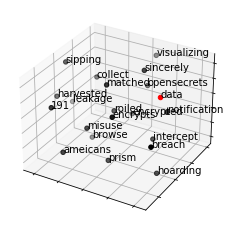

In [111]:
word = "data"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.wv.most_similar(word, topn=20)]
X = nlp.wv[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

# Feature Engineering

In [ ]:
from tensorflow.keras import models, layers, preprocessing as kprocessing

In [112]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [113]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  kylie jenner get long grey lock halloween | len: 7
to:  [ 488  199   13  563 1321 1878  881    0    0    0    0    0    0    0
    0] | len: 15
check:  kylie  -- idx in vocabulary --> 488
vocabulary:  {'NaN': 1, 'trump': 2, 'donald': 3, 'new': 4, 'say': 5} ... (padding element, 0)


In [156]:
corpus = dtf_test["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    


In [164]:
lst_corpus

[['major', 'hunger', 'game', 'theory', 'get', 'support', 'cast'],
 ['trump',
  'team',
  'mulling',
  'muslim',
  'registry',
  'planning',
  'border',
  'wall',
  'reported',
  'adviser',
  'say'],
 ['north', 'west', 'penelope', 'disick', 'gaze', 'truly', 'adorable'],
 ['republican',
  'freak',
  'learning',
  'reagan',
  'decree',
  'protects',
  'lois',
  'lerner'],
 ['report', 'white', 'house', 'mistakenly', 'identifies', 'cia', 'chief'],
 ['avoid', 'impending', 'civil', 'war'],
 ['picking', 'american', 'muslim', 'trump', 'cabinet'],
 ['jeb', 'hillary', 'baggage', 'war'],
 ['grading',
  'top',
  'ten',
  'republican',
  'presidential',
  'candidate',
  'website'],
 ['michael', 'wolff', 'call', 'trump', 'biggest', 'leaker', 'white', 'house'],
 ['life', 'death', 'puerto', 'rico', 'alternative', 'fact'],
 ['black', 'leader', 'speak', 'charlottesville', 'rally', 'face', 'hate'],
 ['pat',
  'mccrory',
  'still',
  'mad',
  'wasnt',
  'reelected',
  'governor',
  'north',
  'carolina'],


In [153]:
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
#These lined caused no change to lst_corpus, why ?

In [ ]:
lst_corpus = list(trigrams_detector[lst_corpus])

In [167]:
list(bigrams_detector[lst_corpus])

[['major', 'hunger game', 'theory', 'get', 'support', 'cast'],
 ['trump',
  'team',
  'mulling',
  'muslim',
  'registry',
  'planning',
  'border wall',
  'reported',
  'adviser',
  'say'],
 ['north west', 'penelope', 'disick', 'gaze', 'truly', 'adorable'],
 ['republican',
  'freak',
  'learning',
  'reagan',
  'decree',
  'protects',
  'lois',
  'lerner'],
 ['report', 'white house', 'mistakenly', 'identifies', 'cia chief'],
 ['avoid', 'impending', 'civil war'],
 ['picking', 'american', 'muslim', 'trump', 'cabinet'],
 ['jeb', 'hillary', 'baggage', 'war'],
 ['grading', 'top', 'ten', 'republican', 'presidential candidate', 'website'],
 ['michael', 'wolff', 'call', 'trump', 'biggest', 'leaker', 'white house'],
 ['life', 'death', 'puerto rico', 'alternative', 'fact'],
 ['black', 'leader', 'speak', 'charlottesville', 'rally', 'face', 'hate'],
 ['pat',
  'mccrory',
  'still',
  'mad',
  'wasnt',
  'reelected',
  'governor',
  'north carolina'],
 ['first',
  'poll',
  'since',
  'james comey

In [154]:

## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [115]:
 ## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [116]:
word = "data"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 533 |idx
embeddings[idx]: (300,) |vector


In [117]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 300)      6730800     input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 300, 15)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 300, 15)      240         permute_1[0][0]                  
_______________________________________________________________________________________

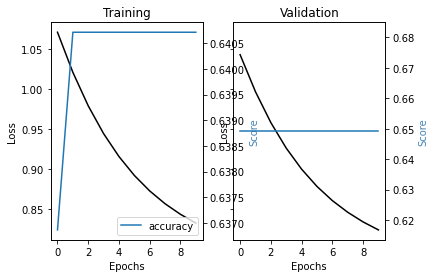

In [118]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()


In [119]:
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]